# EVO 7

## import packages and read h5 files

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, FuncFormatter, MaxNLocator, ScalarFormatter, FixedLocator, LogFormatter

import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [2]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 6 (choke)/Zgabay A14H - choke - strain change rate.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/Anadarko_B2H_(B3H)_CWC/Input/0.1 Hz Diff/merged_B2H_(B3H).h5','r')




print(list(f1.keys()))

['data', 'depth', 'stamps', 'stamps_unix']


## Waterfall plot

In [3]:
from matplotlib import rc
from cycler import cycler

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [4]:
# Assign variables
dstrain = (f1['data'])  #（time, depth）
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

                  0
0          0.039095
1          0.372001
2          0.701719
3          1.031387
4          1.364292
...             ...
57199  18922.408203
57200  18922.738281
57201  18923.070312
57202  18923.398438
57203  18923.728516

[57204 rows x 1 columns]


In [5]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(3415, 57204)


In [6]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.3329055  0.32971793 0.32966805 ... 0.33203125 0.328125   0.33007812]
0.3308164


In [7]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-06-01 07:46:11.600838
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 154.44229406121852


In [8]:
data = dstrain #(time, depth）

# creating a Data2D class instance

DASdata = Data2D_XT.Data2D() # initiate instance
DASdata.data = data.T   # DAS data in 2D array, the first axis is distance and second axis is time

# DASdata.taxis = pd.date_range(start = date_plot[0],end = date_plot[-1],periods = len(date_plot))
DASdata.taxis = t_axis

DASdata.daxis = np.arange(data.shape[1])*average_diff  # 1D array for distance grid, unit in ft
DASdata.start_time = startdate

DASdata.daxis[-1]
print(DASdata.data.shape)

(57204, 3415)


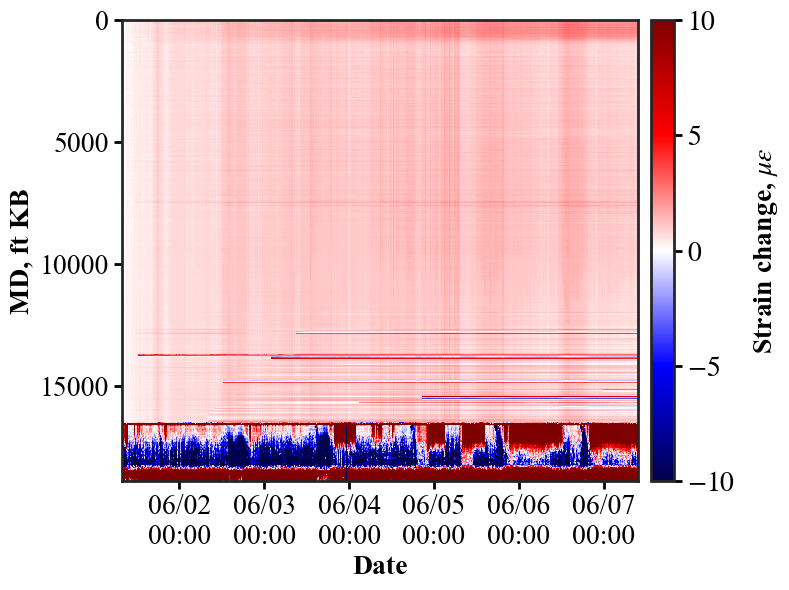

In [9]:
# cx = np.array([-1,1])
# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
fig, ax = plt.subplots(figsize = (8,6))
DASdata.plot_waterfall(timescale='second',use_timestamp=True,cmap=plt.get_cmap('seismic'),xtickN=4)
ax = plt.gca()
im = ax.images[-1]
im.set_norm(TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10))  # 以 0 为中心
# 或者：im.set_clim(-10, 10)

cbar = fig.colorbar(im, ax=ax, pad=0.02) # pad 调整颜色条与图的距离pad 数值越大越远（相对于轴宽度的比例）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=10)

ax.set_ylabel("MD, ft KB", fontweight='bold')
ax.set_xlabel("Date",     fontweight='bold')

# -----------------set custom ticks--------------

# # X 轴
# ax.set_xticks([t0, t1, t2])                     # 位置（数据坐标）
# ax.set_xticklabels(['Start', 'Mid', 'End'])     # 文本（与上面位置一一对应）
ticks = pd.date_range(start='2022-06-02', end='2022-06-07', freq='24h')
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))


# # Y 轴
# ax.set_yticks([0, 5000, 10000])
# ax.set_yticklabels(['0', '5k', '10k'])

# 均匀间隔
# ax.xaxis.set_major_locator(MultipleLocator(3600))     # 每 3600 秒一个大刻度
ax.yaxis.set_major_locator(MultipleLocator(5000))     # 每 2000 ft 一个大刻度

# # 控制刻度文本格式（自定义函数）
# ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v/3600:.1f} h'))
# ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v:.0f}'))

# # 或者仅控制“最多几个刻度”
# ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

# # cbar
# 位置：固定到想要的几档
cbar.set_ticks([-10, -5, 0, 5, 10])                 # 或 cbar.ax.yaxis.set_major_locator(FixedLocator([...]))
# 文本：逐个指定（可含数学字体）
cbar.set_ticklabels([r'$-10$', r'$-5$', r'$0$', r'$5$', r'$10$'])

# # 或者用 Formatter 自动生成文本
# cbar.formatter = FuncFormatter(lambda v, pos: f'{v:.1f}')
# cbar.update_normal(im)   # 某些版本需要刷新一下

# 标签（单位）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=12)


plt.tight_layout()
# plt.savefig('waterfall_ori.png',dpi=1200)


## HFTS-1 Evo-7 pressure

In [12]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from plot_style import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cycler import cycler
from datetime import timedelta
import datetime

# ========= 1) 读取 Excel =========
xls_path = r'C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/13004.xlsx'          # ← 替换为你的文件路径

sheet = 0                             # 或者工作表名，例如 "Sheet1"
df = pd.read_excel(xls_path, sheet_name=sheet, engine="openpyxl")

# 统一列名（去空格、大小写），兼容 "Slurry rate" / "Slurryrate"
df = df.rename(columns={c: c.strip().lower().replace(" ", "") for c in df.columns})

# 期望有：date, whp, slurryrate, concentration
required = {"date", "pressure"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Excel 缺少列: {missing}")

# 时间戳（毫秒）→ pandas datetime（注意：若是秒，把 unit='s'）
t_1 = pd.to_datetime(df["date"], unit="s")  #<class 'pandas.core.series.Series'>       # , utc=True).tz_convert("America/Chicago"
pressure_1 = df["pressure"].astype(float)

#========================= read excel 2 =========
xls_path2 = r'C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/15321.xlsx'           # ← 替换为你的文件路径
sheet2 = 0                             # 或者工作表名，例如 "Sheet1"
df2 = pd.read_excel(xls_path2, sheet_name=sheet2, engine="openpyxl")

# 统一列名（去空格、大小写），兼容 "Slurry rate" / "Slurryrate"
df2 = df2.rename(columns={c: c.strip().lower().replace(" ", "") for c in df2.columns})

# 期望有：date, whp, slurryrate, concentration
required2 = {"date", "pressure"}
missing2 = required2 - set(df2.columns)
if missing2:
    raise ValueError(f"Excel 缺少列: {missing2}")

# 时间戳（毫秒）→ pandas datetime（注意：若是秒，把 unit='s'）
t_2 = pd.to_datetime(df2["date"], unit="s")  #<class 'pandas.core.series.Series'>       # , utc=True).tz_convert("America/Chicago"
pressure_2 = df2["pressure"].astype(float)


In [13]:
length = len(t_1)
print(f"读取 {length} 条记录")
#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2022-05-31 12:00:00")
end   = pd.Timestamp("2022-06-08 06:00:00")

mask_1 = (t_1 >= start) & (t_1 <= end)
mask_2 = (t_2 >= start) & (t_2 <= end)

t_sel_1    = t_1[mask_1]
t_sel_2    = t_2[mask_2]

pressure_sel_1  = pressure_1[mask_1]
pressure_sel_2  = pressure_2[mask_2]


# print(mask_1)
print(len(pressure_sel_1))
print(len(t_sel_1))
print(len(pressure_sel_2))
print(len(t_sel_2))

读取 128 条记录
123
123
142
142


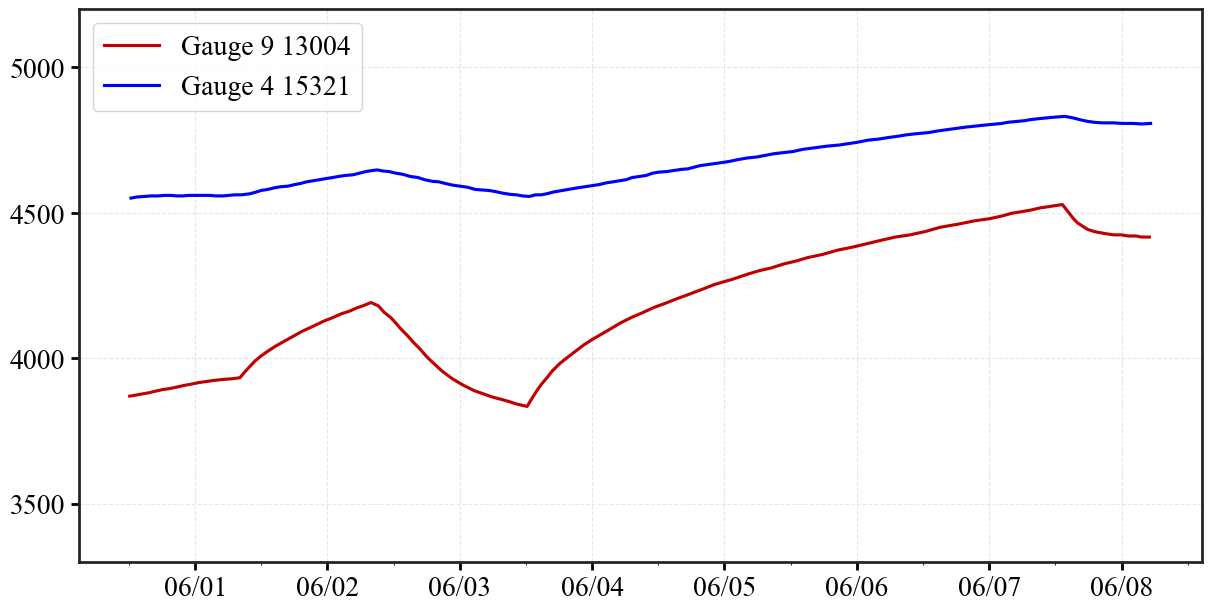

In [14]:

# ========= 2) 画图对象 =========
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符
      
      'axes.labelsize': 36,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 36,        # X轴刻度文字
      'ytick.labelsize': 36,        # Y轴刻度文字
      'legend.fontsize': 36,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 4.0,
      } 
# lack of font size
plt.rcParams.update(rc)

fig, ax1 = make_standard_figure(figsize=(12 , 6))

# ========= 3) 绘制三条曲线 =========
c1, c2 = "#C00000", "blue"

l1, = ax1.plot(t_sel_1, pressure_sel_1, color=c1, lw=2.25, label="Gauge 9 13004")
l2, = ax1.plot(t_sel_2, pressure_sel_2, color=c2, lw=2.25, label="Gauge 4 15321")


# ========= 4) 轴与刻度样式 =========
# ---- y 轴颜色统一（标签、刻度、脊线）----
# 左轴（红）
# ax1.set_ylabel("Treating pressure (psi)", color=c1)
# ax1.tick_params(axis="y", colors=c1, width=1.2)
# ax1.spines["left"].set_color(c1)
# ax1.spines["left"].set_linewidth(1.2)
#set y axis limits
ax1.set_ylim(3300, 5200)
ax1.set_yticks(range(3500, 5001, 500))

# #set y axis ticks
# ax1.set_yticks([3500, 5500])                     # 位置（数据坐标）
# ax1.set_yticklabels(['0', '4000', '8000', '12000', '16000'])     # 文本（与上面位置一一对应）

# 右轴（蓝）← 你关心的部分
# ax2.set_ylabel("Slurry rate (bbl/min)", color=c2)
# ax2.tick_params(axis="y", colors=c2, width=1.2)          # 刻度线/文字变蓝
# ax2.spines["right"].set_color(c2)                        # 右侧竖线变蓝
# ax2.spines["right"].set_linewidth(1.2)
# # ax2.set_ylim(-1000, 18000)
# # #set y axis ticks
# ax2.set_yticks([0, 50])                     # 位置（数据坐标）

# 外侧第三轴（黑）
# ax3.set_ylabel("Proppant conc (lbm/gal)", color=c3, rotation=90, labelpad=30)
# ax3.tick_params(axis="y", colors=c3, width=1.2)
# ax3.spines["right"].set_color(c3)
# ax3.spines["right"].set_linewidth(2.5)
# ax3.set_yticks([0, 100, 200])

# 让第三轴看起来是“外侧的一条竖线带刻度”
# for side in ["left", "top"]:
#     ax3.spines[side].set_visible(False)   # 只保留外侧这条右边竖线
# ax3.spines["right"].set_color(c3)
# ax3.tick_params(axis="y", length=4, width=1.0, colors=c3)

# x 轴时间格式（示例：mm-dd hh）
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d\n%H:%M:%S.{ms})"))
# ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=2))
# fig.autofmt_xdate()  # 倾斜以防重叠
# ax1.set_xlabel("Time mm-dd hh")


# ax1.set_xticks([datetime.datetime(2019,4,1,19,10,00),datetime.datetime(2019,4,1,23,00,00)])                   # 位置（数据坐标）
# ax1.set_xticklabels(['2019-04-01','2019-04-01'])     # 文本（与上面位置一一对应）
# ax.set_yticks([13600, 13800, 14000, 14200, 14400])                     # 位置（数据坐标）
# ax.set_yticklabels(['13600', '13800', '14000', '14200', '14400'])     # 文本（与上面位置一一对应）
import pandas as pd

ticks = pd.date_range(start='2022-06-01', end='2022-06-08', freq='24h')

ax1.set_xticks(ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

from matplotlib.ticker import AutoMinorLocator

ax1.xaxis.set_minor_locator(AutoMinorLocator(2)) 



# 网格（仅主轴网格，避免太花）
ax1.grid(True, linestyle="--", alpha=0.3)

# ========= 5) 图例（合并三条线） =========
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
ax1.legend(loc="upper left")

# 给外侧轴留空间，避免被裁切
# fig.subplots_adjust(right=0.82)
# plt.savefig('frac_curves_S6.png', dpi=600, bbox_inches='tight')
plt.show()



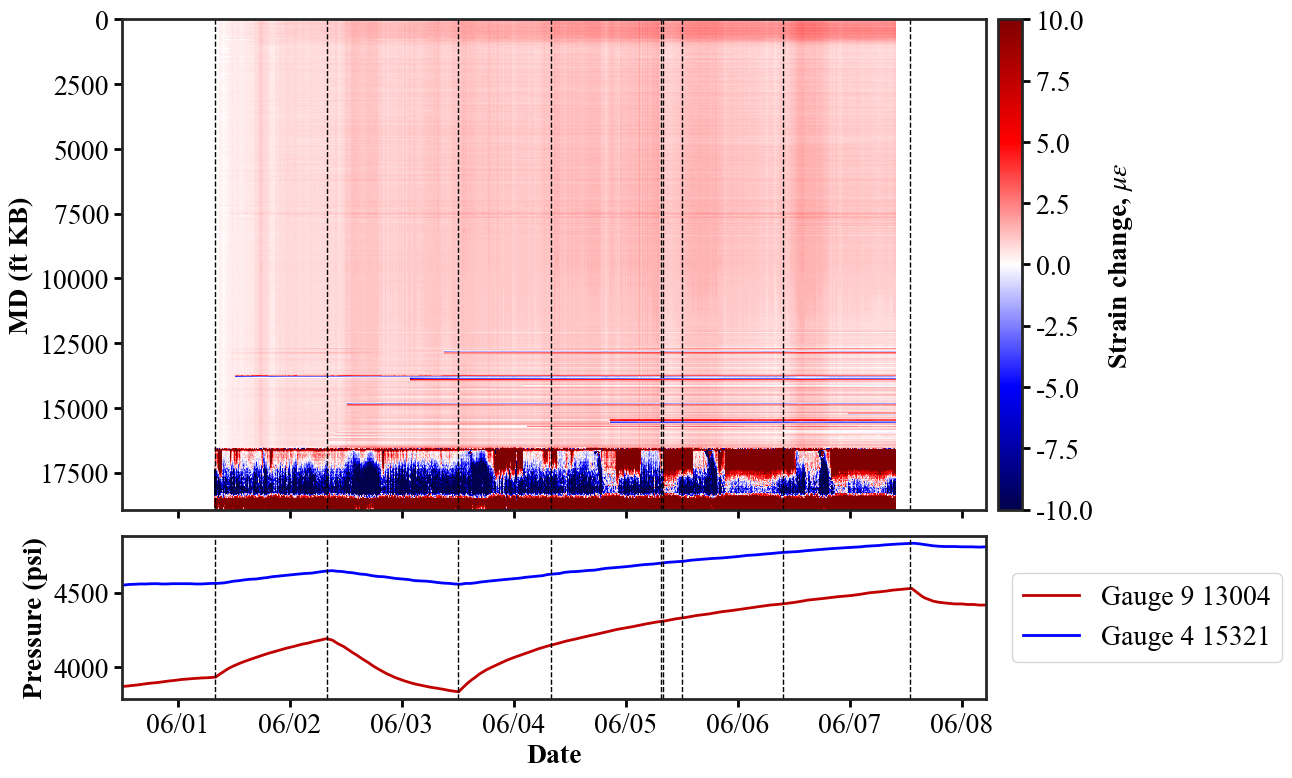

<Figure size 1200x600 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
import datetime

# ================== 1) 先让 plot_waterfall 自己画一次 ==================

fig0, ax0 = plt.subplots()
DASdata.plot_waterfall(
    timescale='second',
    use_timestamp=True,
    cmap=plt.get_cmap('seismic'),
    xtickN=4
)

# 取出已经画好的图像和范围
im0 = ax0.images[-1]
waterfall_array = im0.get_array()   # 2D array
extent0 = im0.get_extent()          # [x_min, x_max, y_min, y_max] （x 是 matplotlib 的日期数）
cmap0 = im0.get_cmap()
origin0 = im0.origin       # 👈 原来的 origin
plt.close(fig0)  # 关掉临时图

# ================== 2) 创建上下两个子图，sharex ==================

fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.08}
)

# --------- 上：重画 waterfall（用原来的 extent，不改时间比例） ---------
im = ax_top.imshow(
    waterfall_array,
    extent=extent0,        # 注意：用原始 extent，不要自己改
    origin=origin0,         # 👈 用原来的，不要写死 'lower'
    aspect="auto",
    cmap=cmap0
)

# 颜色范围
im.set_norm(TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10))

ax_top.set_ylabel("MD (ft KB)", fontweight="bold")

# ================== 3) 下：画 pump curves ==================

c1, c2 = "#C00000", "blue"
ax_bottom.plot(t_sel_1, pressure_sel_1, lw=2.0, color=c1, label="Gauge 9 13004")
ax_bottom.plot(t_sel_2, pressure_sel_2, lw=2.0, color=c2, label="Gauge 4 15321")

ax_bottom.set_ylabel("Pressure (psi)", fontweight="bold")
ax_bottom.set_xlabel("Date", fontweight="bold")
# ax_bottom.legend(loc="upper right")


# 统一时间范围（你可以选：用 pump 全范围，或者只用两者交集）
pump_start = min(t_sel_1.iloc[0], t_sel_2.iloc[0])
pump_end   = max(t_sel_1.iloc[-1], t_sel_2.iloc[-1])
ax_bottom.set_xlim(pump_start, pump_end)

# 时间格式
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax_bottom.xaxis.set_major_locator(mdates.DayLocator(interval=1))



# ================== 4) 添加垂直虚线（测试用）==================


test_time = [datetime.datetime(2022, 6, 1, 8, 0),
             datetime.datetime(2022, 6, 2, 8, 0),
             datetime.datetime(2022, 6, 3, 12, 0),
             datetime.datetime(2022, 6, 4, 8, 0),
             datetime.datetime(2022, 6, 5, 7, 30),
             datetime.datetime(2022, 6, 5, 8, 5),
             datetime.datetime(2022, 6, 5, 12, 0),
             datetime.datetime(2022, 6, 6, 9, 45),
             datetime.datetime(2022, 6, 7, 13, 0)
            ]

for ax in (ax_top, ax_bottom):
    for t in test_time:
        ax.axvline(t, color="k", lw=1, ls="--")


# ================== 5) legend 放到右侧图外（避免和 colorbar 重叠） ==================

# 重新收一点右边界，给 legend + colorbar 一起留空间（可微调）
fig.subplots_adjust(left=0.10, right=0.82, bottom=0.10, top=0.95, hspace=0.08)

# 重新获取 ax_top 的位置（因为 subplots_adjust 改了）
pos_top = ax_top.get_position()
pos_bot = ax_bottom.get_position()

# --- colorbar：仍然严格对齐 ax_top ---
cax = fig.add_axes([
    pos_top.x1 + 0.01,
    pos_top.y0,
    0.02,
    pos_top.height
])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"Strain change, $\mu\varepsilon$", rotation=90, labelpad=10)

# --- legend：放到 ax_bottom 右侧，垂直居中对齐 ax_bottom ---
handles, labels = ax_bottom.get_legend_handles_labels()
# 这里创建一个 figure 级别 legend，更容易放到图外
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(pos_bot.x1 + 0.01, pos_bot.y0 + 0.5 * pos_bot.height),
    bbox_transform=fig.transFigure,
    frameon=True
)



plt.show()
plt.savefig('combo_waterfall_gauge.png', dpi=600, bbox_inches='tight')


# EVO 5

## import packages and read h5 files

In [19]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MultipleLocator, FuncFormatter, MaxNLocator, ScalarFormatter, FixedLocator, LogFormatter

import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [20]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/Zgabay A14H - pop - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 6 (choke)/Zgabay A14H - choke - strain change rate.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/Evo_5_6_7_Sep_2025/Evo 7 (flowback)/Zgabay A14H - flowback - strain change.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/Anadarko_B2H_(B3H)_CWC/Input/0.1 Hz Diff/merged_B2H_(B3H).h5','r')




print(list(f1.keys()))

['data', 'depth', 'stamps', 'stamps_unix']


## Waterfall plot

In [21]:
from matplotlib import rc
from cycler import cycler

# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符


      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

In [22]:
# Assign variables
dstrain = (f1['data'])  #（time, depth）
depth = (f1['depth'])
date_plot = (f1['stamps'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(depth))
# print(pd.DataFrame(date_plot))

                  0
0          0.097321
1          0.429206
2          0.757813
3          1.089698
4          1.418306
...             ...
57213  18866.220703
57214  18866.550781
57215  18866.882812
57216  18867.208984
57217  18867.537109

[57218 rows x 1 columns]


In [23]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(7008, 57218)


In [24]:
#depth 和相邻depth的差值
print(np.diff(depth))
average_diff = np.mean(np.diff(depth))
print(average_diff)


[0.33188438 0.3286078  0.33188438 ... 0.33203125 0.32617188 0.328125  ]
0.32975233


In [25]:
# deal with time array
# print(type(date_plot))  # h5py._hl.dataset.Dataset
# 1) encoding 
arr_bytes = date_plot[...]                      # numpy.ndarray
# print(type(arr_bytes),"arr_bytes")              # numpy.ndarray
arr_str   = np.char.decode(arr_bytes, 'utf-8')  # 向量化解码为 ndarray[str]
# print(type(arr_str),"arr_str")                      # ndarray[str]
datetime_index = pd.to_datetime(arr_str, format="%m/%d/%Y %H:%M:%S.%f")
# print(type(datetime_index))                           # pandas.core.indexes.datetimes.DatetimeIndex
# print("datetime_index\n",datetime_index)

# 2) calculate the start time
dtimes = datetime_index.to_pydatetime()  # type = numpy.ndarray, element type = datetime.datetime
startdate = dtimes[0]
print("startdate-->",startdate)  # 2022-03-14 20:56:49.350706

# 3) calculate average time interval in seconds
deltas = datetime_index.to_series().diff().dropna()   # dropna() 去掉第一个 NaT
print("deltas-->",type(deltas),"\nelement inside-->",type(deltas.iloc[0]))  # pandas.core.series.Series，元素类型为 Timedelta
mean_seconds = deltas.dt.total_seconds().mean()
print("mean_seconds",type(mean_seconds))  # float
print("平均间隔 (秒):", mean_seconds)


# 4) set the time axis for DASdata
t_intrvl = np.round(mean_seconds) # time interval in seconds 
t_axis = 1 + t_intrvl * np.arange(len(date_plot))        # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 


# ts_np = np.array(ts)   # 如果 ts 是 DatetimeIndex，这会生成 datetime64[ns] 数组

# # 1) 计算相邻差（结果是 timedelta64[ns]）
# diffs = np.diff(ts_np)

# # 2) 把 timedelta64[ns] 转换为秒（浮点）
# # 方法：astype('timedelta64[ns]') -> 将其转换为数值（以 ns 为单位），然后除以 1e9
# diffs_ns = diffs.astype('timedelta64[ns]').astype(np.int64)   # ns 为单位的整数
# diffs_seconds = diffs_ns / 1e9

# # 3) 平均秒数
# mean_seconds = np.mean(diffs_seconds)

# print("前 5 个相邻差值（秒）:", diffs_seconds[:5])
# print("平均间隔 (秒):", mean_seconds)


startdate--> 2022-03-14 20:56:49.350706
deltas--> <class 'pandas.core.series.Series'> 
element inside--> <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
mean_seconds <class 'numpy.float64'>
平均间隔 (秒): 84.92036655159127


In [26]:
data = dstrain #(time, depth）

# creating a Data2D class instance

DASdata = Data2D_XT.Data2D() # initiate instance
DASdata.data = data.T   # DAS data in 2D array, the first axis is distance and second axis is time

# DASdata.taxis = pd.date_range(start = date_plot[0],end = date_plot[-1],periods = len(date_plot))
DASdata.taxis = t_axis

DASdata.daxis = np.arange(data.shape[1])*average_diff  # 1D array for distance grid, unit in ft
DASdata.start_time = startdate

DASdata.daxis[-1]
print(DASdata.data.shape)

(57218, 7008)


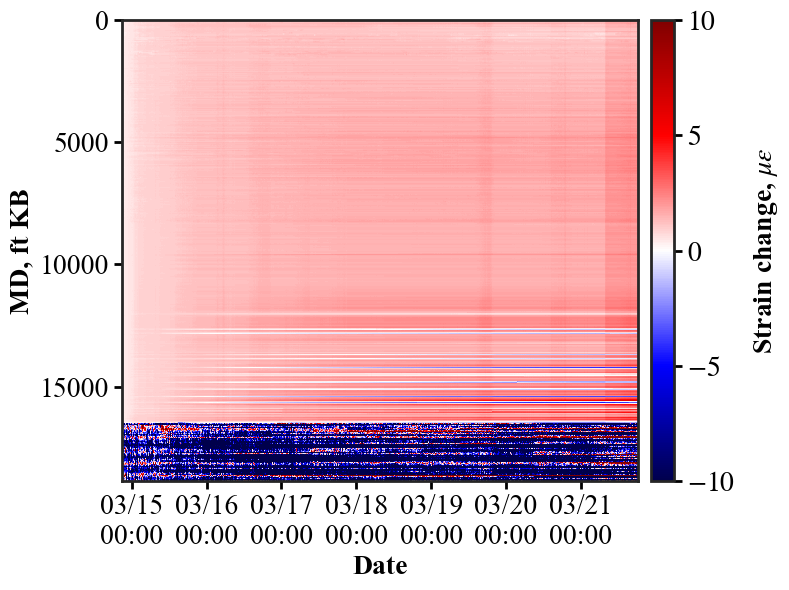

In [27]:
# cx = np.array([-1,1])
# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
fig, ax = plt.subplots(figsize = (8,6))
DASdata.plot_waterfall(timescale='second',use_timestamp=True,cmap=plt.get_cmap('seismic'),xtickN=4)
ax = plt.gca()
im = ax.images[-1]
im.set_norm(TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10))  # 以 0 为中心
# 或者：im.set_clim(-10, 10)

cbar = fig.colorbar(im, ax=ax, pad=0.02) # pad 调整颜色条与图的距离pad 数值越大越远（相对于轴宽度的比例）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=10)

ax.set_ylabel("MD, ft KB", fontweight='bold')
ax.set_xlabel("Date",     fontweight='bold')

# -----------------set custom ticks--------------

# # X 轴
# ax.set_xticks([t0, t1, t2])                     # 位置（数据坐标）
# ax.set_xticklabels(['Start', 'Mid', 'End'])     # 文本（与上面位置一一对应）
# ticks = pd.date_range(start='2022-06-02', end='2022-06-07', freq='24h')
ticks = pd.date_range(start='2022-03-15', end='2022-03-21', freq='24h')
ax.set_xticks(ticks)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))


# # Y 轴
# ax.set_yticks([0, 5000, 10000])
# ax.set_yticklabels(['0', '5k', '10k'])

# 均匀间隔
# ax.xaxis.set_major_locator(MultipleLocator(3600))     # 每 3600 秒一个大刻度
ax.yaxis.set_major_locator(MultipleLocator(5000))     # 每 2000 ft 一个大刻度

# # 控制刻度文本格式（自定义函数）
# ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v/3600:.1f} h'))
# ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f'{v:.0f}'))

# # 或者仅控制“最多几个刻度”
# ax.xaxis.set_major_locator(MaxNLocator(nbins=5))

# # cbar
# 位置：固定到想要的几档
cbar.set_ticks([-10, -5, 0, 5, 10])                 # 或 cbar.ax.yaxis.set_major_locator(FixedLocator([...]))
# 文本：逐个指定（可含数学字体）
cbar.set_ticklabels([r'$-10$', r'$-5$', r'$0$', r'$5$', r'$10$'])

# # 或者用 Formatter 自动生成文本
# cbar.formatter = FuncFormatter(lambda v, pos: f'{v:.1f}')
# cbar.update_normal(im)   # 某些版本需要刷新一下

# 标签（单位）
cbar.set_label(r'Strain change, $\mu\varepsilon$', rotation=90, labelpad=12)


plt.tight_layout()
# plt.savefig('waterfall_ori.png',dpi=1200)


## HFTS-1 Evo-5 pressure

In [28]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from plot_style import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cycler import cycler
from datetime import timedelta
import datetime

# ========= 1) 读取 Excel =========

xls_path = r'C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/13004.xlsx'

sheet = 0                             # 或者工作表名，例如 "Sheet1"
df = pd.read_excel(xls_path, sheet_name=sheet, engine="openpyxl")

# 统一列名（去空格、大小写），兼容 "Slurry rate" / "Slurryrate"
df = df.rename(columns={c: c.strip().lower().replace(" ", "") for c in df.columns})

# 期望有：date, whp, slurryrate, concentration
required = {"date", "pressure"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Excel 缺少列: {missing}")

# 时间戳（毫秒）→ pandas datetime（注意：若是秒，把 unit='s'）
t_1 = pd.to_datetime(df["date"], unit="s")  #<class 'pandas.core.series.Series'>       # , utc=True).tz_convert("America/Chicago"
pressure_1 = df["pressure"].astype(float)

#========================= read excel 2 =========
xls_path2 = r'C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 5 (POP)/15321.xlsx'

sheet2 = 0                             # 或者工作表名，例如 "Sheet1"
df2 = pd.read_excel(xls_path2, sheet_name=sheet2, engine="openpyxl")

# 统一列名（去空格、大小写），兼容 "Slurry rate" / "Slurryrate"
df2 = df2.rename(columns={c: c.strip().lower().replace(" ", "") for c in df2.columns})

# 期望有：date, whp, slurryrate, concentration
required2 = {"date", "pressure"}
missing2 = required2 - set(df2.columns)
if missing2:
    raise ValueError(f"Excel 缺少列: {missing2}")

# 时间戳（毫秒）→ pandas datetime（注意：若是秒，把 unit='s'）
t_2 = pd.to_datetime(df2["date"], unit="s")  #<class 'pandas.core.series.Series'>       # , utc=True).tz_convert("America/Chicago"
pressure_2 = df2["pressure"].astype(float)


In [29]:
print(f"读取 {len(t_1)} 条记录")
print(t_1)

读取 56228 条记录
0       2022-03-15 00:00:00
1       2022-03-15 00:00:10
2       2022-03-15 00:00:20
3       2022-03-15 00:00:30
4       2022-03-15 00:00:40
                ...        
56223   2022-03-21 12:10:30
56224   2022-03-21 12:10:40
56225   2022-03-21 12:10:50
56226   2022-03-21 12:11:00
56227   2022-03-21 12:11:10
Name: date, Length: 56228, dtype: datetime64[ns]


In [30]:
length = len(t_1)
print(f"读取 {length} 条记录")
#取部分数据进行绘图

# ---- 3) 设定你要显示的时间段（同一时区！）----
start = pd.Timestamp("2022-03-15 00:00:00")
end   = pd.Timestamp("2022-03-21 12:00:00")

mask_1 = (t_1 >= start) & (t_1 <= end)
mask_2 = (t_2 >= start) & (t_2 <= end)

t_sel_1    = t_1[mask_1]
t_sel_2    = t_2[mask_2]

pressure_sel_1  = pressure_1[mask_1]
pressure_sel_2  = pressure_2[mask_2]


# print(mask_1)
print(len(pressure_sel_1))
print(len(t_sel_1))
print(len(pressure_sel_2))
print(len(t_sel_2))

读取 56228 条记录
56161
56161
56161
56161


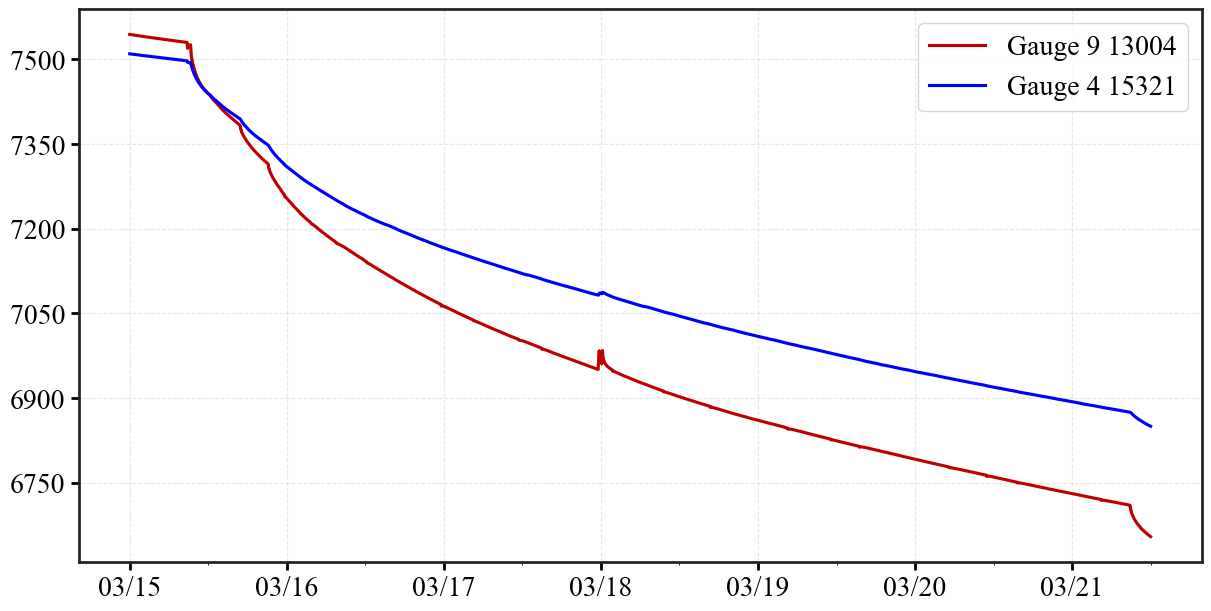

In [31]:

# ========= 2) 画图对象 =========
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      
      'font.family':'Times New Roman',
      'font.serif': ['Times New Roman', 'Times', 'STIXGeneral'],  # 备选
      # —— 数学字体（$...$ 内）——
      'mathtext.fontset': 'stix',     # 关键：让 μ、ε 等用 STIX（Times 风格）
      'axes.unicode_minus': False,    # 让负号显示为正常的连字符
      
      'axes.labelsize': 36,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 36,        # X轴刻度文字
      'ytick.labelsize': 36,        # Y轴刻度文字
      'legend.fontsize': 36,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 4.0,
      } 
# lack of font size
plt.rcParams.update(rc)

fig, ax1 = make_standard_figure(figsize=(12 , 6))

# ========= 3) 绘制三条曲线 =========
c1, c2 = "#C00000", "blue"

l1, = ax1.plot(t_sel_1, pressure_sel_1, color=c1, lw=2.25, label="Gauge 9 13004")
l2, = ax1.plot(t_sel_2, pressure_sel_2, color=c2, lw=2.25, label="Gauge 4 15321")


# ========= 4) 轴与刻度样式 =========
# ---- y 轴颜色统一（标签、刻度、脊线）----
# 左轴（红）
# ax1.set_ylabel("Treating pressure (psi)", color=c1)
# ax1.tick_params(axis="y", colors=c1, width=1.2)
# ax1.spines["left"].set_color(c1)
# ax1.spines["left"].set_linewidth(1.2)
#set y axis limits
# ax1.set_ylim(3300, 5200)
# ax1.set_yticks(range(3500, 5001, 500))

# #set y axis ticks
# ax1.set_yticks([3500, 5500])                     # 位置（数据坐标）
# ax1.set_yticklabels(['0', '4000', '8000', '12000', '16000'])     # 文本（与上面位置一一对应）

# 右轴（蓝）← 你关心的部分
# ax2.set_ylabel("Slurry rate (bbl/min)", color=c2)
# ax2.tick_params(axis="y", colors=c2, width=1.2)          # 刻度线/文字变蓝
# ax2.spines["right"].set_color(c2)                        # 右侧竖线变蓝
# ax2.spines["right"].set_linewidth(1.2)
# # ax2.set_ylim(-1000, 18000)
# # #set y axis ticks
# ax2.set_yticks([0, 50])                     # 位置（数据坐标）

# 外侧第三轴（黑）
# ax3.set_ylabel("Proppant conc (lbm/gal)", color=c3, rotation=90, labelpad=30)
# ax3.tick_params(axis="y", colors=c3, width=1.2)
# ax3.spines["right"].set_color(c3)
# ax3.spines["right"].set_linewidth(2.5)
# ax3.set_yticks([0, 100, 200])

# 让第三轴看起来是“外侧的一条竖线带刻度”
# for side in ["left", "top"]:
#     ax3.spines[side].set_visible(False)   # 只保留外侧这条右边竖线
# ax3.spines["right"].set_color(c3)
# ax3.tick_params(axis="y", length=4, width=1.0, colors=c3)

# x 轴时间格式（示例：mm-dd hh）
# ax1.xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d\n%H:%M:%S.{ms})"))
# ax1.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=2))
# fig.autofmt_xdate()  # 倾斜以防重叠
# ax1.set_xlabel("Time mm-dd hh")


# ax1.set_xticks([datetime.datetime(2019,4,1,19,10,00),datetime.datetime(2019,4,1,23,00,00)])                   # 位置（数据坐标）
# ax1.set_xticklabels(['2019-04-01','2019-04-01'])     # 文本（与上面位置一一对应）
# ax.set_yticks([13600, 13800, 14000, 14200, 14400])                     # 位置（数据坐标）
# ax.set_yticklabels(['13600', '13800', '14000', '14200', '14400'])     # 文本（与上面位置一一对应）
import pandas as pd

ticks = pd.date_range(start='2022-03-15', end='2022-03-21', freq='24h')

ax1.set_xticks(ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

from matplotlib.ticker import AutoMinorLocator

ax1.xaxis.set_minor_locator(AutoMinorLocator(2)) 



# 网格（仅主轴网格，避免太花）
ax1.grid(True, linestyle="--", alpha=0.3)

# ========= 5) 图例（合并三条线） =========
# lines = [l1, l2, l3]
# labels = [ln.get_label() for ln in lines]
ax1.legend(loc="best")

# 给外侧轴留空间，避免被裁切
# fig.subplots_adjust(right=0.82)
# plt.savefig('frac_curves_S6.png', dpi=600, bbox_inches='tight')
plt.show()



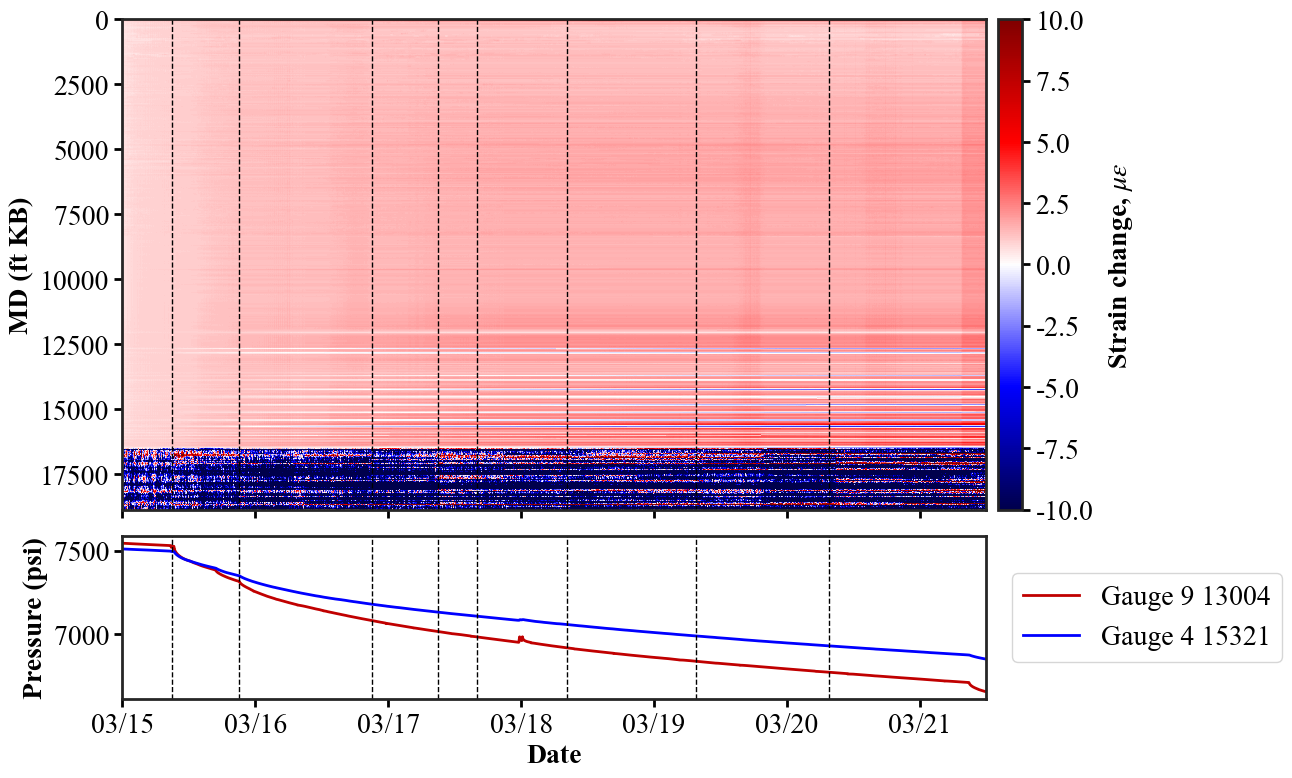

<Figure size 1200x600 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import TwoSlopeNorm
import datetime

# ================== 1) 先让 plot_waterfall 自己画一次 ==================

fig0, ax0 = plt.subplots()
DASdata.plot_waterfall(
    timescale='second',
    use_timestamp=True,
    cmap=plt.get_cmap('seismic'),
    xtickN=4
)

# 取出已经画好的图像和范围
im0 = ax0.images[-1]
waterfall_array = im0.get_array()   # 2D array
extent0 = im0.get_extent()          # [x_min, x_max, y_min, y_max] （x 是 matplotlib 的日期数）
cmap0 = im0.get_cmap()
origin0 = im0.origin       # 👈 原来的 origin
plt.close(fig0)  # 关掉临时图

# ================== 2) 创建上下两个子图，sharex ==================

fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.08}
)

# --------- 上：重画 waterfall（用原来的 extent，不改时间比例） ---------
im = ax_top.imshow(
    waterfall_array,
    extent=extent0,        # 注意：用原始 extent，不要自己改
    origin=origin0,         # 👈 用原来的，不要写死 'lower'
    aspect="auto",
    cmap=cmap0
)

# 颜色范围
im.set_norm(TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10))

ax_top.set_ylabel("MD (ft KB)", fontweight="bold")

# ================== 3) 下：画 pump curves ==================

c1, c2 = "#C00000", "blue"
ax_bottom.plot(t_sel_1, pressure_sel_1, lw=2.0, color=c1, label="Gauge 9 13004")
ax_bottom.plot(t_sel_2, pressure_sel_2, lw=2.0, color=c2, label="Gauge 4 15321")

ax_bottom.set_ylabel("Pressure (psi)", fontweight="bold")
ax_bottom.set_xlabel("Date", fontweight="bold")
# ax_bottom.legend(loc="upper right")


# 统一时间范围（你可以选：用 pump 全范围，或者只用两者交集）
pump_start = min(t_sel_1.iloc[0], t_sel_2.iloc[0])
pump_end   = max(t_sel_1.iloc[-1], t_sel_2.iloc[-1])
ax_bottom.set_xlim(pump_start, pump_end)

# 时间格式
ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax_bottom.xaxis.set_major_locator(mdates.DayLocator(interval=1))



# ================== 4) 添加垂直虚线（测试用）==================


test_time = [datetime.datetime(2022, 3, 15, 9, 0),
             datetime.datetime(2022, 3, 15, 21, 0),
             datetime.datetime(2022, 3, 16, 21, 0),
             datetime.datetime(2022, 3, 17, 9, 0),
             datetime.datetime(2022, 3, 17, 16, 0),
             datetime.datetime(2022, 3, 18, 8, 15),
             datetime.datetime(2022, 3, 19, 7, 30),
             datetime.datetime(2022, 3, 20, 7, 30),

            ]

for ax in (ax_top, ax_bottom):
    for t in test_time:
        ax.axvline(t, color="k", lw=1, ls="--")


# ================== 5) legend 放到右侧图外（避免和 colorbar 重叠） ==================

# 重新收一点右边界，给 legend + colorbar 一起留空间（可微调）
fig.subplots_adjust(left=0.10, right=0.82, bottom=0.10, top=0.95, hspace=0.08)

# 重新获取 ax_top 的位置（因为 subplots_adjust 改了）
pos_top = ax_top.get_position()
pos_bot = ax_bottom.get_position()

# --- colorbar：仍然严格对齐 ax_top ---
cax = fig.add_axes([
    pos_top.x1 + 0.01,
    pos_top.y0,
    0.02,
    pos_top.height
])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"Strain change, $\mu\varepsilon$", rotation=90, labelpad=10)

# --- legend：放到 ax_bottom 右侧，垂直居中对齐 ax_bottom ---
handles, labels = ax_bottom.get_legend_handles_labels()
# 这里创建一个 figure 级别 legend，更容易放到图外
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(pos_bot.x1 + 0.01, pos_bot.y0 + 0.5 * pos_bot.height),
    bbox_transform=fig.transFigure,
    frameon=True
)



plt.show()
plt.savefig('combo_waterfall_gauge.png', dpi=600, bbox_inches='tight')
